# Estudo de Caso: KDD Cup 2009

A Administração de Relacionamento com o Consumidor é um elemento-chave das estratégias modernas de marketing. A maneira mais prática de adquirir conhecimento sobre consumidores é produzindo pontuações. Uma pontuação é a saída de um modelo e serve como avaliação de todas as instâncias de uma variável-alvo que se pretenda explicar. Ferramentas que produzem pontuações permitem projetar informações quantificáveis em uma dada população. A pontuação é calculada usando variáveis de entrada que descrevem as instâncias. As pontuações são então usadas pelo sistema de informação, por exemplo, para personalizar o relacionamento com o consumidor.

Em 2009, a conferência Knowledge Discovery and Data Mining (KDD) lançou um desafio envolvendo aprendizagem de máquina. Ela disponibilizou dados de consumidores da empresa de telecomunicações francesa Orange, que deveriam ser utilizados para a construção de um modelo capaz de prever três comportamentos do consumidor. A planilha fornecida tem 50000 instâncias de 230 variáveis, sendo as primeiras 190 variáveis numéricas e as demais 40 categóricas. As variáveis de saída do modelo eram o cancelamento da conta ('churn'), a tendência de usar novos produtos e serviços ('appetency') e a propensão para comprar upgrades ou adicionais com maior margem de lucro quando apresentados (upselling), fornecidos de forma binária (-1 para *não*, 1 para *sim*).

O trabalho apresentado aqui envolve a criação de um modelo para predição de *churn*, *appetency* e *upselling* com base nos dados fornecidos dos clientes da Orange. O critério para avaliação do modelo será a métrica AUC, que dimensiona o trade-off entre taxa de falsos positivos e taxa de verdadeiros positivos: quanto mais próximo de 1, menor o trade-off e melhor o modelo.

## Modelando 'churn'

### Importando as dependências

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

### Carregando os dados

In [2]:
path = 'C:/Users/Denny/Documents/Data Science/Hekima/'
features = pd.read_csv(path + 'orange_small_train.data', sep = '\t', na_filter = False)
outcome = pd.read_csv(path + 'orange_small_train_churn.labels', header = None)

### Identificando as variáveis numéricas e categóricas

In [3]:
all_vars = np.array(features.columns)
num_vars = np.array(all_vars[:190])
cat_vars = np.array(all_vars[190:])

### Verificando a consistência das variáveis

De forma a verificar se algumas entradas de variáveis são inconsistentes, eu proponho primeiro verificar se todas as entradas das variáveis numéricas são mesmo números. Para tanto, vou primeiro gerar uma tabela com a contagem de todos os valores presentes nas variáveis numéricas, depois ordenar os valores, e então imprimir os primeiros e os últimos valores.

In [4]:
counts_per_col = pd.DataFrame()
for col in num_vars:
    print('Processing', col, '/', len(num_vars), end = '\r')
    col_count = features.groupby(col).size()
    counts_per_col = counts_per_col.append(col_count, ignore_index = True)
counts_per_col = counts_per_col.T
counts_per_col.index = counts_per_col.index.astype('str')
counts_per_col.sort_index(inplace = True)
print('Primeiras dez categorias: ', counts_per_col.index[:10])
print('Últimas dez categorias: ', counts_per_col.index[(len(counts_per_col.index)-10):])

Primeiras dez categorias:  Index(['', '-10', '-1000060.0', '-10002.16', '-100034.8', '-1000420.0',
       '-1000468.0', '-1000496.0', '-1000516.0', '-1000548.0'],
      dtype='object')
Últimas dez categorias:  Index(['9999040', '999920', '9999240', '99993', '9999400', '9999440',
       '9999480', '99995', '99996', '999971'],
      dtype='object')


Observa-se que o primeiro valor corresponde às entradas vazias (dados faltantes), mas as demais são consistentes com o tipo de dado esperado.

Farei o mesmo para as variáveis categóricas.

In [5]:
counts_per_col = pd.DataFrame()
for col in cat_vars:
    print('Processing', col, '/', len(all_vars), end = '\r')
    col_count = features.groupby(col).size()
    counts_per_col = counts_per_col.append(col_count, ignore_index = True)
counts_per_col = counts_per_col.T
counts_per_col.index = counts_per_col.index.astype('str')
counts_per_col.sort_index(inplace = True)
print('Primeiras dez categorias: ', counts_per_col.index[:10])
print('Últimas dez categorias: ', counts_per_col.index[(len(counts_per_col.index)-10):])

Primeiras dez categorias:  Index(['', '000J', '0062', '00AD', '00ARusu', '00AYONy', '00AhP4J', '00J8E9a',27 / 230 Var228 / 230
       '00JHTSP', '00L3'],
      dtype='object')
Últimas dez categorias:  Index(['zzQ9udm', 'zzQV', 'zzbGOGx', 'zzbGa54', 'zzcv6yg4s3UGv', 'zzfHvGh',
       'zzfLM_S', 'zzfUfAI', 'zzfo6HG', 'zzpZ'],
      dtype='object')


Também se observa que os dados são consistentes. Então vou substituir as entradas vazias por `NaN`.

In [6]:
features = features.replace('', np.nan)

Agora vou corrigir o tipo dos dados no dataframe, de forma a refletir os dados que ele contém.

In [7]:
for col in num_vars:
    features[col] = features[col].astype('float')
for col in cat_vars:
    features[col] = features[col].astype('category')

### Seleção de variáveis

#### Variáveis com muitos valores faltantes

Primeiro vou verificar o número de valores faltantes em cada variável. Os gráficos representam a soma de variáveis em função de quantos valores faltantes elas possuem.

48513.0


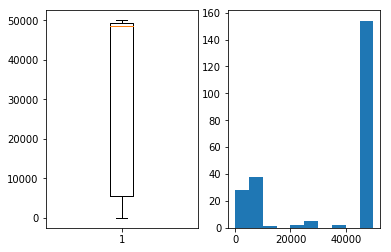

In [8]:
empty_entries_per_column = features.isna().sum(axis = 0)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.boxplot(empty_entries_per_column)
ax2.hist(empty_entries_per_column)
median = empty_entries_per_column.median()
print(median)

Observa-se que um número grande de variáveis possuem valores faltantes. De acordo com o boxplot, 50% das variáveis possuem mais de 48513 (97%) valores faltantes. O histograma mostra um número considerável de variáveis contendo menos de 10000 valores faltantes. Sendo assim, vou optar por manter apenas as variáveis que possuam no máximo 10000 valores faltantes (25% do total de instâncias).

In [9]:
num_entries = len(features)
threshold = 0.25
keep_vars = np.array(features.columns[(empty_entries_per_column <= (num_entries * threshold))])

# Atualizando os índices:
num_vars = [elem for elem in num_vars if elem in keep_vars]
cat_vars = [elem for elem in cat_vars if elem in keep_vars]

Então vou preecher os valores faltantes. Para as variáveis numéricas, vou preencher com a média da variável. Para as variáveis categóricas, vou preencher com a categoria 'missing'.

In [10]:
for col in num_vars:
    col_mean = features[col].mean()
    features[col] = features[col].fillna(col_mean)
for col in cat_vars:
    features[col] = features[col].cat.add_categories('missing')
    features[col] = features[col].fillna('missing')

#### Variáveis categóricas com muitas categorias

Vou agora verificar quantas categorias cada variável categórica contém.

Var192      362
Var193       51
Var195       23
Var196        4
Var197      226
Var198     4291
Var199     5074
Var202     5714
Var203        6
Var204      100
Var205        4
Var206       22
Var207       14
Var208        3
Var210        6
Var211        2
Var212       81
Var216     2016
Var217    13991
Var218        3
Var219       23
Var220     4291
Var221        7
Var222     4291
Var223        5
Var226       23
Var227        7
Var228       30
dtype: int64


(array([21.,  1.,  0.,  4.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([2.00000e+00, 1.40090e+03, 2.79980e+03, 4.19870e+03, 5.59760e+03,
        6.99650e+03, 8.39540e+03, 9.79430e+03, 1.11932e+04, 1.25921e+04,
        1.39910e+04]),
 <a list of 10 Patch objects>)

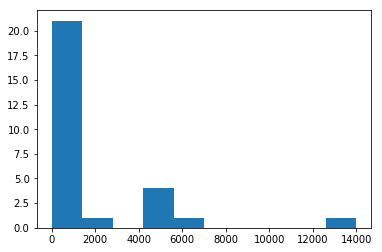

In [11]:
n_categories_per_feature = features[cat_vars].apply(lambda x: len(set(x)))
print(n_categories_per_feature)
plt.hist(n_categories_per_feature)

A maioria das variáveis, 21 de 28 (75%), contêm até 1400 categorias. Eu não acredito que variáveis muito diversas sejam úteis, já que elas provavelmente representam comentários que seriam mais difíceis para traduzir em informação. Dessa forma, vou manter apenas as variáveis categóricas que contenham menos de 1400 categorias.

In [12]:
cat_vars = np.array(n_categories_per_feature[n_categories_per_feature < 1400].index)

Finalmente, consolidando o dataframe:

In [13]:
features = features[list(num_vars)+list(cat_vars)]

In [14]:
features.shape

(50000, 59)

Temos agora 59 variáveis remanescentes.

Como, até esse ponto, o pré-processamento das variáveis era independente da variável de saída do modelo, vou manter o dataframe `features` para reutilização com as demais variáveis de saída, e criar novos dataframes a partir dele para o processamento a seguir. A partir daqui, também vou criar funções em cada etapa para facilitar a construção dos demais modelos.

#### Seleção de variáveis baseada em árvore de decisão

Com o objetivo de verificar quais variáveis são mais importantes na definição da variável de saída do modelo, vou usar o algoritmo `ExtraTreesClassifier`. Como a partir daqui eu só pretendo trabalhar com árvores de decisão em função da natureza dos dados (grande quantidade de variáveis tanto numéricas quanto categóricas), primeiro vou gerar variáveis dummy para as variáveis categóricas; nesse caso, vou gerar um dataframe `features_c` para o modelo correspondente a `churn`.

In [15]:
features_c = pd.get_dummies(features)

In [16]:
def etc_importances(features, outcome):
    ### Essa função treina um modelo do tipo ExtraTreesClassifier para determinação da importãncia de cada variável de entrada,
    ### depois ordena as variáveis por ordem decrescente de importância, e retorna tanto as variáveis ordenadas quanto
    ### os valores de importância ordenados.
    
    # Construindo e treinando o modelo
    model = ExtraTreesClassifier(n_estimators = 200, criterion = 'entropy', verbose = 0, n_jobs = 3, random_state = 0)
    model.fit(features, np.array(outcome).ravel())

    # Extraindo a importância das variáveis
    importances = model.feature_importances_
    # Extraindo o nome das variáveis
    variables = np.array(features.columns)
    # Ordenando as importâncias por ordem decrescente
    indices = np.argsort(importances)[::-1]
    importances = importances[indices]
    variables = variables[indices]
    
    return variables, importances

In [17]:
variables, importances = etc_importances(features_c, outcome)

Agora vou gerar um gráfico mostrando a soma cumulativa das importâncias relativas, ordenadas por ordem decrescente de importância, de modo a verificar se mais variáveis podem ser descartadas.

In [18]:
def sum_and_plot_importances(variables, importances):
    ### Essa função calculada a soma acumulada das importâncias das variáveis de entrada e plota um gráfico do número
    ### de variáveis por soma acumulada. A função retorna um dataframe contendo o nome das variáveis, na ordem decrescente
    ### de importância, e a soma acumulada de importância até aquela variável. 
    
    sum_importances = pd.DataFrame()
    for i in range(importances.size):
        sum_importance = importances[:(i+1)].sum()
        this_variable = pd.Series([variables[i], sum_importance])
        sum_importances = sum_importances.append(this_variable, ignore_index = True)
    plt.scatter(sum_importances.index, sum_importances.iloc[:, 1])
    return sum_importances

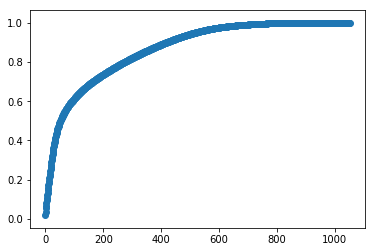

In [19]:
sum_importances = sum_and_plot_importances(variables, importances)

Observa-se que as primeiras 800 variáveis representam quase 100% da importância do modelo. Vou adotar uma linha de corte de 99% de importância acumulada para descartar as variáveis de menor importância.

In [20]:
def keep_vars(features, sum_importances, threshold):
    ### Essa função recebe um dataframe contendo as variáveis de entrada, um dataframe contendo a soma acumulada das importâncias
    ### por variável de entrada, e um limite a ser aplicado para a soma acumulada, e retorna um dataframe com as variáveis de
    ### entrada que atendam o limite de importância acumulada.
    
    threshold = threshold
    keep_vars = list(sum_importances[sum_importances.iloc[:, 1] <= threshold].iloc[:, 0])
    features = features.loc[:, keep_vars]
    
    return features

In [21]:
features_c = keep_vars(features_c, sum_importances, threshold = 0.99)

In [22]:
features_c.shape

(50000, 685)

O dataframe resultante, contendo 685 variáveis, está pronto para ser usado na construção do modelo.

## Dividindo os dados em dataset para treino e dataset para teste

Vou optar por manter 20% dos dados num dataset para teste. Não vou criar um dataset para validação pois pretendo usar validação cruzada na construção dos modelos. Uma vez que a variável de saída não é balanceada, vou usar estratificação na hora de dividir os datasets.

In [23]:
def split_datasets(features, outcome, test_size = 0.2):
    ### Essa função recebe um dataframe contendo as variáveis de entrada, um dataframe contendo a variável de saída, um
    ### valor indicando o percentual de instâncias a ser destinado para o dataset de teste, e faz a divisão dos datasets em
    ### treino e teste, estratificada em função do dataframe contendo a variável de saída.
    
    # Dividindo em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size = test_size, stratify = outcome, random_state = 0)

    # Formatando as variáveis de saída para alimentar o modelo
    y_train, y_test = np.array(y_train).ravel(), np.array(y_test).ravel()
    
    return X_train, X_test, y_train, y_test

In [24]:
X_train, X_test, y_train, y_test = split_datasets(features_c, outcome)

### Modelagem preliminar

Pretendo testar preliminarmente um modelo usando `RandomForestClassifier` e um modelo usando `GradientBoostingClassifier`, com alguns parâmetros padronizados, para realizar a otimização no modelo de melhor desempenho. A métrica AUC será avaliada por validação cruzada com 5 dobras do dataset de treinamento.

#### Random Forest Classifier

In [25]:
def rfc_test(X_train, y_train, n_estimators = 100, cv = 5):
    ### Essa função constrói um modelo de classificação do tipo árvore aleatória, avaliado pela métrica AUC com validação 
    ### cruzada de 5 dobras, e retorna a média da métrica AUC calculada nas 5 dobras.
    np.random.seed(0)
    
    rfc = RandomForestClassifier(n_estimators = n_estimators, random_state = 0, n_jobs = 3)
    cv_scores = cross_val_score(rfc, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs = 3)
    print('Média dos cinco modelos: ', cv_scores.mean())

In [26]:
rfc_test(X_train, y_train)

Média dos cinco modelos:  0.6224107938322838


#### Gradient Boosting Classifer

In [27]:
def gbc_test(X_train, y_train, n_estimators = 100, learning_rate = 0.1, cv = 5):
    ### Essa função constrói um modelo de classificação do tipo boosting gradiente, avaliado pela métrica AUC com validação 
    ### cruzada de 5 dobras, e retorna a média da métrica AUC calculada nas 5 dobras.
    np.random.seed(0)
    
    gbc = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, random_state = 0)
    cv_scores = cross_val_score(gbc, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs = 3)
    print('Média dos cinco modelos: ', cv_scores.mean())

In [28]:
gbc_test(X_train, y_train)

Média dos cinco modelos:  0.6711445148493931


O modelo `GradientBoostingClassifier` tem um desempenho superior e será otimizado.

## Otimizando o modelo GBC

A otimização será realizada em etapas. Primeiro vou usar uma taxa de aprendizagem (`learning_rate`) alta para otimizar os demais parâmetros, depois vou otimizar a taxa de aprendizagem junto com o número de estimadores (`n_estimators`).

### Otimizando `n_estimators` para `learning_rate` = 0.1

In [29]:
def optimize(n_estimators, learning_rate, min_samples_split, min_samples_leaf, max_depth, max_features, subsample, params, cv = 5):
    ### Essa função calcula a média da métrica AUC em 5 dobras do dataset de treinamento fornecido, com base nos parâmetros
    ### de modelo e nos parâmetros para otimização também fornecidos, usando o modelo de classificação do tipo boosting
    ### gradiente, e retorna o modelo (sem treinamento), os melhores parâmetros que estavam sendo otimizados, e a média da
    ### métrica AUC.
    
    # Definindo o estado aleatório
    np.random.seed(0)
    
    # Definição do modelo
    gbc = GradientBoostingClassifier(n_estimators = n_estimators, 
                                     learning_rate = learning_rate,
                                     min_samples_split = min_samples_split,
                                     min_samples_leaf = min_samples_leaf, 
                                     max_depth = max_depth, 
                                     max_features = max_features, 
                                     subsample = subsample, 
                                     random_state = 0)
    # Construção do otimizador grid search
    grid_search = GridSearchCV(estimator = gbc, param_grid = params, scoring = 'roc_auc', n_jobs = 3, iid = False, cv = cv)
    # Treinamento do otimizador
    grid_search.fit(X_train, y_train)
    # Processamento dos resultados
    results = grid_search.cv_results_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(best_params, best_score)
    
    return gbc, best_params, best_score

In [30]:
# Inicializando algumas variáveis para coletar os resultados

models = np.array([])
opt_params = dict()
scores = np.array([])

In [31]:
### MODELO 0

learning_rate = 0.1
n_estimators = None
max_depth = 8
min_samples_split = 250
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'n_estimators': range(50, 151, 10)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'n_estimators': 60} 0.6654320677976999


In [32]:
# Atualizando as variáveis contendo os resultados

models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

### Otimizando `max_depth` e `min_samples_split`

In [33]:
### MODELO 1

n_estimators = opt_params['n_estimators']
max_depth = None
min_samples_split = None
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'max_depth': range(3, 12, 2), 'min_samples_split': range(150, 401, 50)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'max_depth': 7, 'min_samples_split': 300} 0.6715353727289998


In [34]:
# Atualizando as variáveis contendo os resultados

models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

### Otimizando `min_samples_leaf`

In [35]:
### MODELO 2

max_depth = opt_params['max_depth']
min_samples_split = opt_params['min_samples_split']
min_samples_leaf = None
max_features = 'sqrt'
subsample = 0.8
params = {'min_samples_leaf': range(25, 61, 5)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'min_samples_leaf': 45} 0.6729449847001296


In [36]:
# Atualizando as variáveis contendo os resultados

models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

### Otimizando `max_features`

In [37]:
### MODELO 3

min_samples_leaf = opt_params['min_samples_leaf']
max_features = None
subsample = 0.8
params = {'max_features': range(21, 31, 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'max_features': 26} 0.6729449847001296


In [38]:
# Atualizando as variáveis contendo os resultados

models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

### Otimizando `subsample`

In [39]:
### MODELO 4

max_features = opt_params['max_features']
subsample = None
params = {'subsample': np.append(np.arange(0.6, 1, 0.05), 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'subsample': 0.8000000000000002} 0.6729449847001296


In [40]:
# Atualizando as variáveis contendo os resultados

models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

### Otimizando `n_estimators` e `learning_rate`

A partir daqui, vou reduzir a taxa de aprendizagem `learning_rate` enquanto ao mesmo tempo aumento o número de estimadores `n_estimators` proporcionalmente. A função de otimização `optimize_2` também vai retornar um gráfico com as métricas AUC para cada etapa de otimização desde o início, incluindo a métrica calculada na etapa em questão.

In [41]:
def optimize_2(n_estimators, learning_rate, min_samples_split, min_samples_leaf, max_depth, max_features, subsample, params, cv = 5):
    ### Essa função calcula a média da métrica AUC em 5 dobras do dataset de treinamento fornecido, com base nos parâmetros
    ### de modelo e nos parâmetros para otimização também fornecidos, usando o modelo de classificação do tipo boosting
    ### gradiente, e retorna o modelo (sem treinamento) e a média da métrica AUC. Ela também plota uma figura com a métrica AUC
    ### calculada para cada etapa de otimização desde o início.
    
    # Definindo o estado aleatório
    np.random.seed(0)
    
    # Definição do modelo
    gbc = GradientBoostingClassifier(n_estimators = n_estimators, 
                                     learning_rate = learning_rate,
                                     min_samples_split = min_samples_split,
                                     min_samples_leaf = min_samples_leaf, 
                                     max_depth = max_depth, 
                                     max_features = max_features, 
                                     subsample = subsample, 
                                     random_state = 0)
    # Cálculo da métrica AUC com validação cruzada
    cv_scores = cross_val_score(gbc, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs = 3)
    score = cv_scores.mean()
    plt.plot(np.append(scores, score))
    plt.title('n_estimators = {} ... learning_rate = {}'.format(n_estimators, learning_rate))
    
    return gbc, score

In [42]:
# Definindo variáveis com o número de estimadores *n_estimators* e a taxa de aprendizagem *learning_rate* utilizados até aqui

learning_rate = 0.1
n_estimators = opt_params['n_estimators']

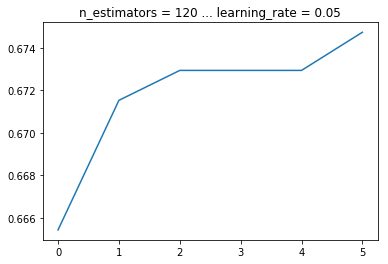

In [43]:
### MODELO 5

subsample = opt_params['subsample']
learning_rate /= 2
n_estimators *= 2

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [44]:
# Atualizando as variáveis contendo os resultados

models = np.append(models, gbc);
scores = np.append(scores, score);

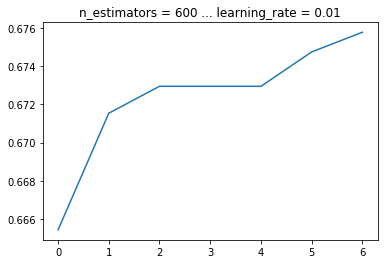

In [45]:
### MODELO 6

learning_rate /= 5
n_estimators *= 5

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [46]:
# Atualizando as variáveis contendo os resultados

models = np.append(models, gbc);
scores = np.append(scores, score);

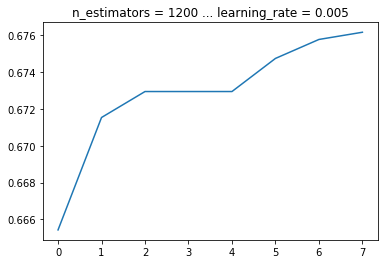

In [47]:
### MODELO 7

learning_rate /= 2
n_estimators *= 2

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [48]:
# Atualizando as variáveis contendo os resultados

models = np.append(models, gbc);
scores = np.append(scores, score);

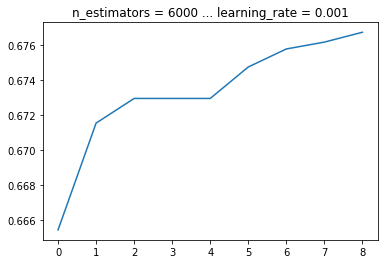

In [49]:
### MODELO 8

learning_rate /= 5
n_estimators *= 5

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [50]:
# Atualizando as variáveis contendo os resultados

models = np.append(models, gbc);
scores = np.append(scores, score);

In [51]:
print('Modelo de melhor desempenho: ', scores.argmax(), ' - AUC: ', max(scores))

Modelo de melhor desempenho:  8  - AUC:  0.6767276625799957


O melhor modelo alcançou AUC de `0.6767` no dataset de treinamento. Finalmente, vou treinar esse modelo com o dataset completo de treinamento e calcular a métrica AUC no dataset de teste.

In [52]:
best_model = models[scores.argmax()]
best_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=7,
              max_features=26, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=45, min_samples_split=300,
              min_weight_fraction_leaf=0.0, n_estimators=6000,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=0.8000000000000002, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [53]:
y_pred_probs = best_model.predict_proba(X_test)
roc_auc_score(y_test, y_pred_probs[:, 1])

0.6850952561031483

**Conclusão:** O modelo otimizado atingiu AUC de `0.6851` no dataset de teste.

## Modelando 'appetency'

O modelo para a nova variável de saída só precisa ser atualizado a partir da seleção de variáveis através de árvore de decisão. Primeiro vou carregar os dados correspondentes à variável `appetency`, depois vou prosseguir com o pré-processamento do dataframe `features` até o final, repetindo o processo descrito acima.

In [54]:
outcome = pd.read_csv(path + 'orange_small_train_appetency.labels', header = None)

In [55]:
features_a = pd.get_dummies(features)

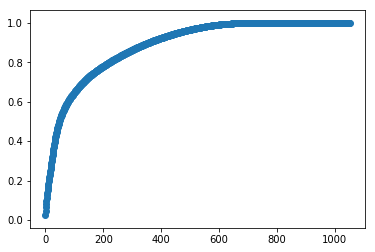

In [56]:
variables, importances = etc_importances(features_a, outcome)
sum_importances = sum_and_plot_importances(variables, importances)

In [57]:
features_a = keep_vars(features_a, sum_importances, threshold = 0.99)
features_a.shape

(50000, 591)

In [58]:
X_train, X_test, y_train, y_test = split_datasets(features_a, outcome)

In [59]:
rfc_test(X_train, y_train)

Média dos cinco modelos:  0.678986753683195


In [60]:
gbc_test(X_train, y_train)

Média dos cinco modelos:  0.7542200720086567


In [61]:
models = np.array([])
opt_params = dict()
scores = np.array([])

In [62]:
### MODELO 0

learning_rate = 0.1
n_estimators = None
max_depth = 8
min_samples_split = 250
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'n_estimators': range(10, 101, 10)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'n_estimators': 30} 0.7345255481129098


In [63]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [64]:
### MODELO 1

n_estimators = opt_params['n_estimators']
max_depth = None
min_samples_split = None
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'max_depth': range(1, 7, 1), 'min_samples_split': range(50, 151, 50)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'max_depth': 5, 'min_samples_split': 100} 0.7391809856792442


In [65]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [66]:
### MODELO 2

max_depth = opt_params['max_depth']
min_samples_split = opt_params['min_samples_split']
min_samples_leaf = None
max_features = 'sqrt'
subsample = 0.8
params = {'min_samples_leaf': range(1, 11, 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'min_samples_leaf': 2} 0.7515813180647919


In [67]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [68]:
### MODELO 3

min_samples_leaf = opt_params['min_samples_leaf']
max_features = None
subsample = 0.8
params = {'max_features': range(21, 31, 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'max_features': 28} 0.760034571219339


In [69]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [70]:
### MODELO 4

max_features =  opt_params['max_features']
subsample = None
params = {'subsample': np.append(np.arange(0.6, 1, 0.05), 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'subsample': 0.9000000000000002} 0.7610709789848987


In [71]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [72]:
learning_rate = 0.1
n_estimators = opt_params['n_estimators']

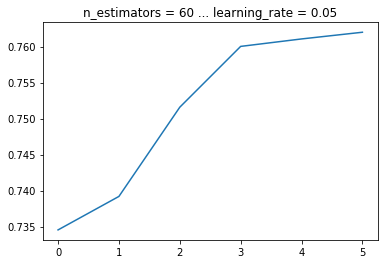

In [73]:
### MODELO 5

subsample = opt_params['subsample']
learning_rate /= 2
n_estimators *= 2

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [74]:
models = np.append(models, gbc);
scores = np.append(scores, score);

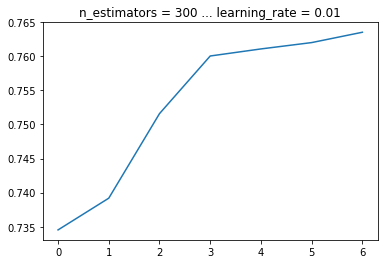

In [75]:
### MODELO 6

learning_rate /= 5
n_estimators *= 5

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [76]:
models = np.append(models, gbc);
scores = np.append(scores, score);

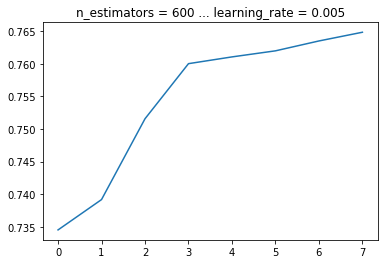

In [77]:
### MODELO 7

learning_rate /= 2
n_estimators *= 2

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [78]:
models = np.append(models, gbc);
scores = np.append(scores, score);

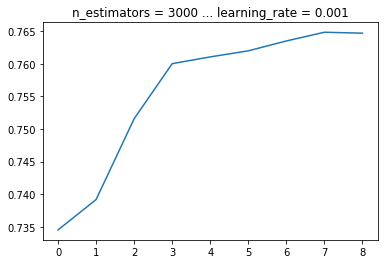

In [79]:
### MODELO 8

learning_rate /= 5
n_estimators *= 5

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [80]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [81]:
print('Modelo de melhor desempenho: ', scores.argmax(), ' - AUC: ', max(scores))

Modelo de melhor desempenho:  7  - AUC:  0.7648550498041831


In [82]:
best_model = models[scores.argmax()]
best_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=5,
              max_features=28, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=100,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=0.9000000000000002, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [83]:
y_pred_probs = best_model.predict_proba(X_test)
roc_auc_score(y_test, y_pred_probs[:, 1])

0.7954983538444995

**Conclusão:** O modelo otimizado atingiu AUC de `0.7955` no dataset de teste.

## Modelando 'upselling'

In [84]:
outcome = pd.read_csv(path + 'orange_small_train_upselling.labels', header = None)

In [85]:
features_u = pd.get_dummies(features)

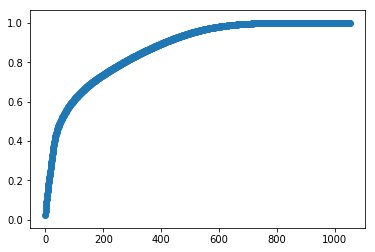

In [86]:
variables, importances = etc_importances(features_u, outcome)
sum_importances = sum_and_plot_importances(variables, importances)

In [87]:
features_u = keep_vars(features_u, sum_importances, threshold = 0.99)
features_u.shape

(50000, 647)

In [88]:
X_train, X_test, y_train, y_test = split_datasets(features_u, outcome)

In [89]:
rfc_test(X_train, y_train)

Média dos cinco modelos:  0.6998437587803525


In [90]:
gbc_test(X_train, y_train)

Média dos cinco modelos:  0.7500558467034699


In [91]:
models = np.array([])
opt_params = dict()
scores = np.array([])

In [92]:
### MODELO 0

learning_rate = 0.1
n_estimators = None
max_depth = 8
min_samples_split = 250
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'n_estimators': range(50, 101, 10)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'n_estimators': 100} 0.7462279885340164


In [93]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [94]:
### MODELO 1

n_estimators = opt_params['n_estimators']
max_depth = None
min_samples_split = None
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'max_depth': range(3, 12, 2), 'min_samples_split': range(150, 401, 50)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'max_depth': 7, 'min_samples_split': 300} 0.7498432245612576


In [95]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [96]:
### MODELO 2

max_depth = opt_params['max_depth']
min_samples_split = opt_params['min_samples_split']
min_samples_leaf = None
max_features = 'sqrt'
subsample = 0.8
params = {'min_samples_leaf': range(5, 50, 5)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'min_samples_leaf': 40} 0.7501157401273872


In [97]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [98]:
### MODELO 3

min_samples_leaf = opt_params['min_samples_leaf']
max_features = None
subsample = 0.8
params = {'max_features': range(20, 31, 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'max_features': 25} 0.7501157401273872


In [99]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [100]:
### MODELO 4

max_features =  opt_params['max_features']
subsample = None
params = {'subsample': np.append(np.arange(0.6, 1, 0.05), 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'subsample': 0.8000000000000002} 0.7501157401273872


In [101]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [102]:
learning_rate = 0.1
n_estimators = opt_params['n_estimators']

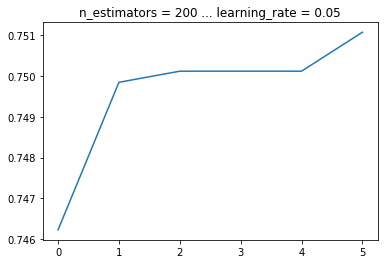

In [103]:
### MODELO 5

subsample = opt_params['subsample']
learning_rate /= 2
n_estimators *= 2

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [104]:
models = np.append(models, gbc);
scores = np.append(scores, score);

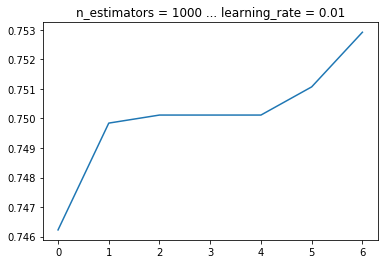

In [105]:
### MODELO 6

learning_rate /= 5
n_estimators *= 5

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [106]:
models = np.append(models, gbc);
scores = np.append(scores, score);

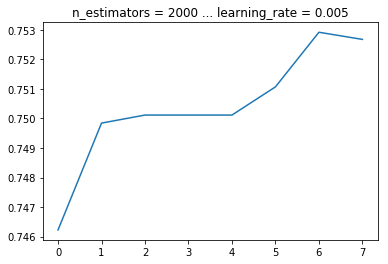

In [107]:
### MODELO 7

learning_rate /= 2
n_estimators *= 2

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [108]:
models = np.append(models, gbc);
scores = np.append(scores, score);

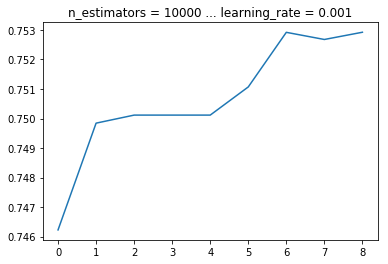

In [109]:
### MODELO 8

learning_rate /= 5
n_estimators *= 5

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [110]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [111]:
print('Modelo de melhor desempenho: ', scores.argmax(), ' - AUC: ', max(scores))

Modelo de melhor desempenho:  8  - AUC:  0.7529214938490817


In [112]:
best_model = models[scores.argmax()]
best_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=7,
              max_features=25, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=40, min_samples_split=300,
              min_weight_fraction_leaf=0.0, n_estimators=10000,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=0.8000000000000002, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [113]:
y_pred_probs = best_model.predict_proba(X_test)
roc_auc_score(y_test, y_pred_probs[:, 1])

0.7621693019261094

**Conclusão:** O modelo otimizado atingiu AUC de `0.7622` no dataset de teste.